# Apply LDA to the paragraph set to identify candidate topics

## Data wrangling
### Clean up paragraph text data. Remove punctuation; lowercase the text.

In [1]:
import pandas as pd
import string

# data wrangling/cleaning
paragraphs_df = pd.read_csv('election_paragraphs.csv', delimiter = '///', engine = 'python')

# remove punctuation
paragraphs_df['Paragraph'] = paragraphs_df['Paragraph'].apply(lambda x: ''.join([c for c in x if c not in string.punctuation]))

# lowercase paragraph text
paragraphs_df = paragraphs_df.apply(lambda x: x.str.lower())

### Results

In [2]:
paragraphs_df

,Date,Paragraph
0,2000-05-01,following are excerpts from remarks prepared f...
1,2000-05-01,from what we can tell of his foreign policy go...
2,2000-05-01,governor bush dangerously fixates on the cold ...
3,2000-05-01,stuck in a cold war mindset governor bush cont...
4,2000-05-01,just this past week governor bush used his bri...
...,...,...
16497,2000-10-31,battleground states where votes for mr nader c...
16498,2000-10-31,at least five sites are dedicated to what some...
16499,2000-10-31,before the debates i really expected gore to s...
16500,2000-10-31,mr porter acknowledges that the idea has a pot...


### Vectorizing the text

In [3]:
import pandas as pd

# helper function: returns the k most frequently appearing keywords in the dataframe
def top_k(data_df, vec, k):
    X = vec.fit_transform(data_df['Paragraph'].values)
    labels = vec.get_feature_names()
    
    return pd.DataFrame(columns = labels, data = X.toarray()).sum().sort_values(ascending = False)[:k]

In [4]:
## generate feature vectors
from sklearn.feature_extraction.text import CountVectorizer 

vec = CountVectorizer(decode_error = 'ignore', stop_words = 'english')
X = vec.fit_transform(paragraphs_df['Paragraph'].values)

#### Most frequent terms over all paragraphs

In [5]:
top_terms = top_k(paragraphs_df, vec, 30)

top_terms

mr              21849
bush            11095
gore            10284
said             6844
president        3809
campaign         3464
bushs            2623
gores            2494
vice             2284
george           2103
al               2060
republican       1656
people           1583
clinton          1573
governor         1470
texas            1433
like             1397
new              1394
today            1372
tax              1274
voters           1268
plan             1181
gov              1168
years            1159
democratic       1153
did              1138
presidential     1074
time             1067
national         1025
debate           1015
dtype: int64

## Topic modeling with LDA

In [6]:
# helper function: prints the top k candidate topics
def print_topics(topic_model, vec, k):
    terms = vec.get_feature_names()
    for topic_idx, topic in enumerate(topic_model.components_):
        print("Topic #%d:" %topic_idx)
        print(" ".join([terms[i] for i in topic.argsort()[:-k - 1:-1]]) + '\n')

In [7]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

tn = 30
lda = LDA(n_components = tn)
lda.fit(X)

LatentDirichletAllocation(n_components=30)

### Candidate topics

In [8]:
print_topics(lda, vec, 10)

Topic #0:
bush president george vice gov al gore campaign presidential mr

Topic #1:
florida bush mr jeb brother gore like george mrs day

Topic #2:
mr bush military president gore american war administration clinton said

Topic #3:
mr gun bush control gore money bushs campaign governor said

Topic #4:
board mr bush execution case reprieve state graham dna death

Topic #5:
mr bush gore said bushs governor republican clinton campaign gores

Topic #6:
mr gore bush president question vice said lehrer debate answer

Topic #7:
mr bush mccain john senator gore said republican bushs gores

Topic #8:
bush missile united states mr test defense nuclear national gore

Topic #9:
mr gore bush campaign democrats republicans said states voters democratic

Topic #10:
said gore mr people dont think know bush going want

Topic #11:
mr bush said texas gore bushs hughes time campaign speech

Topic #12:
mr bush oil policy foreign administration prices said energy gore

Topic #13:
mr gore health environment

In [9]:
# transform document word matrix according to the fitted LDA model
document_topic_distribution = lda.transform(X)
document_topic_df = pd.DataFrame(document_topic_distribution)
document_topic_df['Date'] = paragraphs_df['Date']

topic_coverage = document_topic_df.groupby(['Date']).agg({i: 'sum' for i in range(30)})

### Topic coverage results

In [10]:
topic_coverage

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,
2000-05-01,8.936573,0.927446,2.063842,0.778400,0.082633,3.648274,1.107559,0.988870,2.147539,4.096873,...,13.819814,2.051764,0.252555,0.828327,1.055975,0.345988,1.948168,1.465966,0.245117,1.983733
2000-05-02,1.887959,0.999753,0.154685,1.371059,0.068025,0.760811,0.686313,0.866386,0.282987,1.805551,...,0.094098,0.152453,0.063499,0.030056,0.075457,0.030056,2.386819,0.257091,0.482714,1.326094
2000-05-03,6.265377,0.068363,1.523522,1.942006,0.437769,1.576761,0.562188,0.736858,0.417137,4.075601,...,9.013804,1.903103,0.068363,3.211629,7.400832,0.567283,0.644838,2.384358,0.764373,0.331654
2000-05-05,5.485658,0.620023,0.336264,4.054625,0.167949,3.868985,2.840712,1.083615,0.352957,4.791389,...,4.785069,0.579515,0.789655,3.543144,2.392289,0.528999,2.957879,1.010262,1.378376,1.836606
2000-05-06,3.430553,0.235427,1.030687,5.127076,0.186178,1.495121,0.513300,0.998148,0.290102,2.136565,...,0.323091,0.615383,0.060687,0.622163,2.411635,0.292878,2.041226,2.408488,0.542783,0.457025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-10-27,7.590521,2.741029,3.291831,1.567907,0.526862,2.884216,0.996155,3.250113,1.896318,19.649495,...,6.126064,2.193333,1.349577,5.035460,5.701573,6.574248,2.871873,1.661452,2.847149,14.835405
2000-10-28,9.868255,0.384799,2.223271,2.404233,1.181490,4.487740,2.019959,4.324098,1.803025,19.408893,...,6.111221,1.868506,1.663687,7.566237,4.550939,5.559662,10.782941,3.478886,4.998852,6.099814
2000-10-29,10.870907,2.323559,4.991423,8.683013,1.584717,9.849011,4.604320,4.269529,1.914179,15.286911,...,5.868702,2.158760,2.597467,7.109213,10.109081,8.858260,9.168096,3.396739,2.529112,6.362821


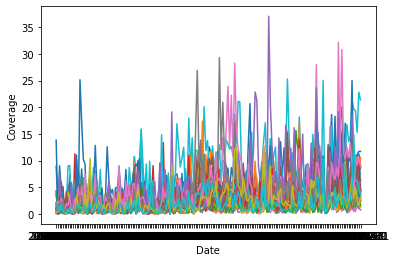

In [11]:
import matplotlib.pyplot as plt

plt.plot(topic_coverage)
plt.ylabel('Coverage')
plt.xlabel('Date')
plt.show()

# Iowa Electronic Markets (IEM) 2000 Presidential Winner-Takes-All Market

## Data wrangling

In [12]:
import datetime 

# helper function to standardize date formatting between datasets
def format_date(date):
    return datetime.datetime.strptime(date, '%m/%d/%y').strftime('20%y-%m-%d')

In [13]:
import pandas as pd

iem_prices_df = pd.read_csv('iem_2000.txt', delimiter = '\t')
iem_prices_df = iem_prices_df.drop(['    Units', '    $Volume', '    LowPrice', '    HighPrice', '    AvgPrice'], axis = 1)
iem_prices_df['Date'] = iem_prices_df['Date'].apply(lambda x: format_date(x))
iem_prices_df = iem_prices_df.set_index('Date')

### Democratic candidate prices 

In [14]:
dem_prices_df = iem_prices_df[iem_prices_df['    Contract'].str.contains('Dem')]
dem_prices_df

,Contract,LastPrice
Date,,
2000-05-01,Dem,0.550
2000-05-02,Dem,0.508
2000-05-03,Dem,0.510
2000-05-04,Dem,0.513
2000-05-05,Dem,0.524
...,...,...
2000-10-27,Dem,0.387
2000-10-28,Dem,0.287
2000-10-29,Dem,0.354


### Republican candidate prices

In [15]:
rep_prices_df = iem_prices_df[iem_prices_df['    Contract'].str.contains('Rep')]
rep_prices_df

,Contract,LastPrice
Date,,
2000-05-01,Rep,0.500
2000-05-02,Rep,0.498
2000-05-03,Rep,0.491
2000-05-04,Rep,0.490
2000-05-05,Rep,0.482
...,...,...
2000-10-27,Rep,0.620
2000-10-28,Rep,0.681
2000-10-29,Rep,0.670


In [16]:
dem_normalized_prices = dem_prices_df['    LastPrice'] / (dem_prices_df['    LastPrice'] + rep_prices_df['    LastPrice'])
dem_normalized_prices_df = dem_normalized_prices.to_frame()
dem_normalized_prices_df = dem_normalized_prices_df.rename(columns = {'    LastPrice': 'NormalizedPrice'})
dem_normalized_prices_df

,NormalizedPrice
Date,
2000-05-01,0.523810
2000-05-02,0.504970
2000-05-03,0.509491
2000-05-04,0.511466
2000-05-05,0.520875
...,...
2000-10-27,0.384310
2000-10-28,0.296488
2000-10-29,0.345703


## Election coverage vs. election forecast

In [17]:
election_prices_topics = pd.concat([dem_normalized_prices_df, topic_coverage], axis = 1, join = 'inner')

election_prices_topics

,NormalizedPrice,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,
2000-05-01,0.523810,8.936573,0.927446,2.063842,0.778400,0.082633,3.648274,1.107559,0.988870,2.147539,...,13.819814,2.051764,0.252555,0.828327,1.055975,0.345988,1.948168,1.465966,0.245117,1.983733
2000-05-02,0.504970,1.887959,0.999753,0.154685,1.371059,0.068025,0.760811,0.686313,0.866386,0.282987,...,0.094098,0.152453,0.063499,0.030056,0.075457,0.030056,2.386819,0.257091,0.482714,1.326094
2000-05-03,0.509491,6.265377,0.068363,1.523522,1.942006,0.437769,1.576761,0.562188,0.736858,0.417137,...,9.013804,1.903103,0.068363,3.211629,7.400832,0.567283,0.644838,2.384358,0.764373,0.331654
2000-05-05,0.520875,5.485658,0.620023,0.336264,4.054625,0.167949,3.868985,2.840712,1.083615,0.352957,...,4.785069,0.579515,0.789655,3.543144,2.392289,0.528999,2.957879,1.010262,1.378376,1.836606
2000-05-06,0.515060,3.430553,0.235427,1.030687,5.127076,0.186178,1.495121,0.513300,0.998148,0.290102,...,0.323091,0.615383,0.060687,0.622163,2.411635,0.292878,2.041226,2.408488,0.542783,0.457025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-10-27,0.384310,7.590521,2.741029,3.291831,1.567907,0.526862,2.884216,0.996155,3.250113,1.896318,...,6.126064,2.193333,1.349577,5.035460,5.701573,6.574248,2.871873,1.661452,2.847149,14.835405
2000-10-28,0.296488,9.868255,0.384799,2.223271,2.404233,1.181490,4.487740,2.019959,4.324098,1.803025,...,6.111221,1.868506,1.663687,7.566237,4.550939,5.559662,10.782941,3.478886,4.998852,6.099814
2000-10-29,0.345703,10.870907,2.323559,4.991423,8.683013,1.584717,9.849011,4.604320,4.269529,1.914179,...,5.868702,2.158760,2.597467,7.109213,10.109081,8.858260,9.168096,3.396739,2.529112,6.362821


# Granger testing

In [18]:
from statsmodels.tsa.stattools import grangercausalitytests as gct

lag = 3
granger_test_results = list()
for i in range(0, len(election_prices_topics.columns) - 1):
    result = gct(election_prices_topics[['NormalizedPrice', i]], maxlag = lag, verbose = True)
    granger_test_results.append(result)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3451  , p=0.5577  , df_denom=174, df_num=1
ssr based chi2 test:   chi2=0.3511  , p=0.5535  , df=1
likelihood ratio test: chi2=0.3507  , p=0.5537  , df=1
parameter F test:         F=0.3451  , p=0.5577  , df_denom=174, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4104  , p=0.6640  , df_denom=171, df_num=2
ssr based chi2 test:   chi2=0.8448  , p=0.6555  , df=2
likelihood ratio test: chi2=0.8427  , p=0.6561  , df=2
parameter F test:         F=0.4104  , p=0.6640  , df_denom=171, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5342  , p=0.6595  , df_denom=168, df_num=3
ssr based chi2 test:   chi2=1.6692  , p=0.6438  , df=3
likelihood ratio test: chi2=1.6613  , p=0.6456  , df=3
parameter F test:         F=0.5342  , p=0.6595  , df_denom=168, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0672  , p=0.7958  

ssr based F test:         F=3.5127  , p=0.0165  , df_denom=168, df_num=3
ssr based chi2 test:   chi2=10.9770 , p=0.0119  , df=3
likelihood ratio test: chi2=10.6465 , p=0.0138  , df=3
parameter F test:         F=3.5127  , p=0.0165  , df_denom=168, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7141  , p=0.3992  , df_denom=174, df_num=1
ssr based chi2 test:   chi2=0.7264  , p=0.3940  , df=1
likelihood ratio test: chi2=0.7250  , p=0.3945  , df=1
parameter F test:         F=0.7141  , p=0.3992  , df_denom=174, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7296  , p=0.4836  , df_denom=171, df_num=2
ssr based chi2 test:   chi2=1.5018  , p=0.4719  , df=2
likelihood ratio test: chi2=1.4954  , p=0.4734  , df=2
parameter F test:         F=0.7296  , p=0.4836  , df_denom=171, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6947  , p=0.5565  , df_denom=168, df_num=3
ssr based chi2 test: 

likelihood ratio test: chi2=1.5168  , p=0.6784  , df=3
parameter F test:         F=0.4875  , p=0.6914  , df_denom=168, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6038  , p=0.4382  , df_denom=174, df_num=1
ssr based chi2 test:   chi2=0.6142  , p=0.4332  , df=1
likelihood ratio test: chi2=0.6132  , p=0.4336  , df=1
parameter F test:         F=0.6038  , p=0.4382  , df_denom=174, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6542  , p=0.5212  , df_denom=171, df_num=2
ssr based chi2 test:   chi2=1.3467  , p=0.5100  , df=2
likelihood ratio test: chi2=1.3415  , p=0.5113  , df=2
parameter F test:         F=0.6542  , p=0.5212  , df_denom=171, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6273  , p=0.5983  , df_denom=168, df_num=3
ssr based chi2 test:   chi2=1.9603  , p=0.5807  , df=3
likelihood ratio test: chi2=1.9494  , p=0.5830  , df=3
parameter F test:         F=0.6273  , p

# Significant causal words

## Compute average p-values across time lags

In [19]:
p_values = dict()

for i in range(len(granger_test_results)):
    p_value = 0
    for j in range(1, lag):
        p_value += granger_test_results[i][j][0]['params_ftest'][1]
    p_value /= lag
    p_values[i] = p_value
                
p_values

{0: 0.4072362573296777,
 1: 0.3127036635563911,
 2: 0.0566257665050428,
 3: 0.3421494067878314,
 4: 0.5014164632907002,
 5: 0.3163907768385998,
 6: 0.14549943028481205,
 7: 0.23715323697828905,
 8: 0.2802023402616333,
 9: 0.6579243181656107,
 10: 0.14334280569100824,
 11: 0.5528680112186507,
 12: 0.6523712102881484,
 13: 0.5644964752706362,
 14: 0.18475884432835243,
 15: 0.29428206082410163,
 16: 0.4110065072560826,
 17: 0.5337193107645696,
 18: 0.2871116100124389,
 19: 0.33363864760995215,
 20: 0.05533559305881396,
 21: 0.4814509465346523,
 22: 0.450845457469463,
 23: 0.614756884379348,
 24: 0.3197768769273342,
 25: 0.13215049081232264,
 26: 0.08839802483102858,
 27: 0.6319753361478865,
 28: 0.2737003964530517,
 29: 0.02341006808154657}

## Terms sorted by causality probability

In [20]:
p_values = dict(sorted(p_values.items(), key = lambda entry: entry[1]))

p_values

{29: 0.02341006808154657,
 20: 0.05533559305881396,
 2: 0.0566257665050428,
 26: 0.08839802483102858,
 25: 0.13215049081232264,
 10: 0.14334280569100824,
 6: 0.14549943028481205,
 14: 0.18475884432835243,
 7: 0.23715323697828905,
 28: 0.2737003964530517,
 8: 0.2802023402616333,
 18: 0.2871116100124389,
 15: 0.29428206082410163,
 1: 0.3127036635563911,
 5: 0.3163907768385998,
 24: 0.3197768769273342,
 19: 0.33363864760995215,
 3: 0.3421494067878314,
 0: 0.4072362573296777,
 16: 0.4110065072560826,
 22: 0.450845457469463,
 21: 0.4814509465346523,
 4: 0.5014164632907002,
 17: 0.5337193107645696,
 11: 0.5528680112186507,
 13: 0.5644964752706362,
 23: 0.614756884379348,
 27: 0.6319753361478865,
 12: 0.6523712102881484,
 9: 0.6579243181656107}

# Prior influence

## Positive impact terms

In [21]:
list(p_values)[:15]

[29, 20, 2, 26, 25, 10, 6, 14, 7, 28, 8, 18, 15, 1, 5]

## Negative impact terms

In [22]:
list(p_values)[15:]

[24, 19, 3, 0, 16, 22, 21, 4, 17, 11, 13, 23, 27, 12, 9]

# Visualization

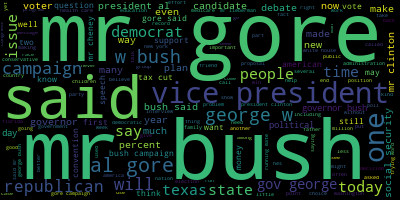

In [23]:
from wordcloud import WordCloud

all_paragraphs = ' '.join(list(paragraphs_df['Paragraph'].values))
wordcloud = WordCloud(max_words = 300)
wordcloud.generate(all_paragraphs)
wordcloud.to_image()